In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from data import StrokeDataset
from model import StrokeEncoder
from pixel_decoder import PixelDecoder, ReconstructionModel

# 自动检测设备
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch, 'xpu') and torch.xpu.is_available():
    device = 'xpu'

print(f"使用设备: {device}")

/run/media/fuwaki/Workspace/Workspace/Python/InkTrace/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用设备: xpu


/run/media/fuwaki/Workspace/Workspace/Python/InkTrace/.venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/run/media/fuwaki/Workspace/Workspace/Python/InkTrace/RepVit.py:277: UserWarning: Overwriting repvit_m0_9 in registry with RepVit.repvit_m0_9. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def repvit_m0_9(pretrained=False, num_classes = 1000, distillation=False):
/run/media/fuwaki/Workspace/Workspace/Python/InkTrace/RepVit.py:313: UserWarning: Overwriting repvit_m1_0 in registry with RepVit.repvit_m1_0. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def repvit_m1_0(pretrained=False, num_classes = 1000, distillation=False):
/run/media

In [2]:
# ==================== 配置超参数 ====================
config = {
    'batch_size': 32,
    'lr': 1e-3,
    'num_epochs': 50,
    'embed_dim': 128,  # 降低到 128，CPU 友好
    'num_heads': 4,
    'num_layers': 6,
}

print("训练配置:")
for k, v in config.items():
    print(f"  {k}: {v}")

训练配置:
  batch_size: 32
  lr: 0.001
  num_epochs: 50
  embed_dim: 128
  num_heads: 4
  num_layers: 6


In [3]:
# ==================== 创建数据集 ====================
dataset = StrokeDataset(size=64, length=10000)
train_loader = DataLoader(
    dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True if device != 'cpu' else False
)

print(f"数据集大小: {len(dataset)}")
print(f"批次数: {len(train_loader)}")

# 测试加载一个 batch
imgs, labels = next(iter(train_loader))
print(f"\nBatch 形状:")
print(f"  Images: {imgs.shape}")
print(f"  Labels: {labels.shape}")

数据集大小: 10000
批次数: 313

Batch 形状:
  Images: torch.Size([32, 1, 64, 64])
  Labels: torch.Size([32, 10])


In [5]:
# ==================== 创建模型 ====================
encoder = StrokeEncoder(
    in_channels=1,
    embed_dim=config['embed_dim'],
    num_heads=config['num_heads'],
    num_layers=config['num_layers'],
    dropout=0.1
)

decoder = PixelDecoder(
    embed_dim=config['embed_dim']
)

model = ReconstructionModel(encoder, decoder).to(device)

# 统计参数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"模型参数:")
print(f"  总参数: {total_params:,}")
print(f"  可训练参数: {trainable_params:,}")

模型参数:
  总参数: 1,855,265
  可训练参数: 1,855,265


In [6]:
# ==================== 损失函数和优化器 ====================
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=config['num_epochs']
)

print("训练配置:")
print(f"  损失函数: MSE Loss")
print(f"  优化器: Adam (lr={config['lr']})")
print(f"  调度器: CosineAnnealingLR")

训练配置:
  损失函数: MSE Loss
  优化器: Adam (lr=0.001)
  调度器: CosineAnnealingLR


In [8]:
# ==================== 测试前向传播 ====================
# 先获取一个 batch 的测试数据
test_imgs_batch, test_labels_batch = next(iter(train_loader))

model.eval()
with torch.no_grad():
    test_imgs = test_imgs_batch[:4].to(device)
    test_recon, test_emb = model(test_imgs)
    
print(f"测试前向传播:")
print(f"  输入: {test_imgs.shape}")
print(f"  重建: {test_recon.shape}")
print(f"  Embedding: {test_emb.shape}")
print(f"  重建范围: [{test_recon.min():.3f}, {test_recon.max():.3f}]")

# 计算测试损失
test_loss = criterion(test_recon, test_imgs)
print(f"  初始损失: {test_loss.item():.6f}")

测试前向传播:
  输入: torch.Size([4, 1, 64, 64])
  重建: torch.Size([4, 1, 64, 64])
  Embedding: torch.Size([4, 64, 128])
  重建范围: [0.483, 0.494]
  初始损失: 0.238232


In [7]:
# ==================== 训练循环 ====================
history = {'train_loss': []}
best_loss = float('inf')

num_epochs = config['num_epochs']

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        
        # 前向传播
        optimizer.zero_grad()
        reconstructed, embeddings = model(imgs)
        
        # 计算损失
        loss = criterion(reconstructed, imgs)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # 每 100 个 batch 打印一次
        if (batch_idx + 1) % 100 == 0:
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.6f}")
    
    # 更新学习率
    scheduler.step()
    
    # 计算平均损失
    avg_loss = epoch_loss / len(train_loader)
    history['train_loss'].append(avg_loss)
    
    # 保存最佳模型
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, 'best_reconstruction.pth')
    
    # 打印 epoch 统计
    print(f"\nEpoch {epoch}/{num_epochs}")
    print(f"  平均损失: {avg_loss:.6f}")
    print(f"  最佳损失: {best_loss:.6f}")
    print(f"  学习率: {optimizer.param_groups[0]['lr']:.6f}")
    print("-" * 60)

KeyboardInterrupt: 

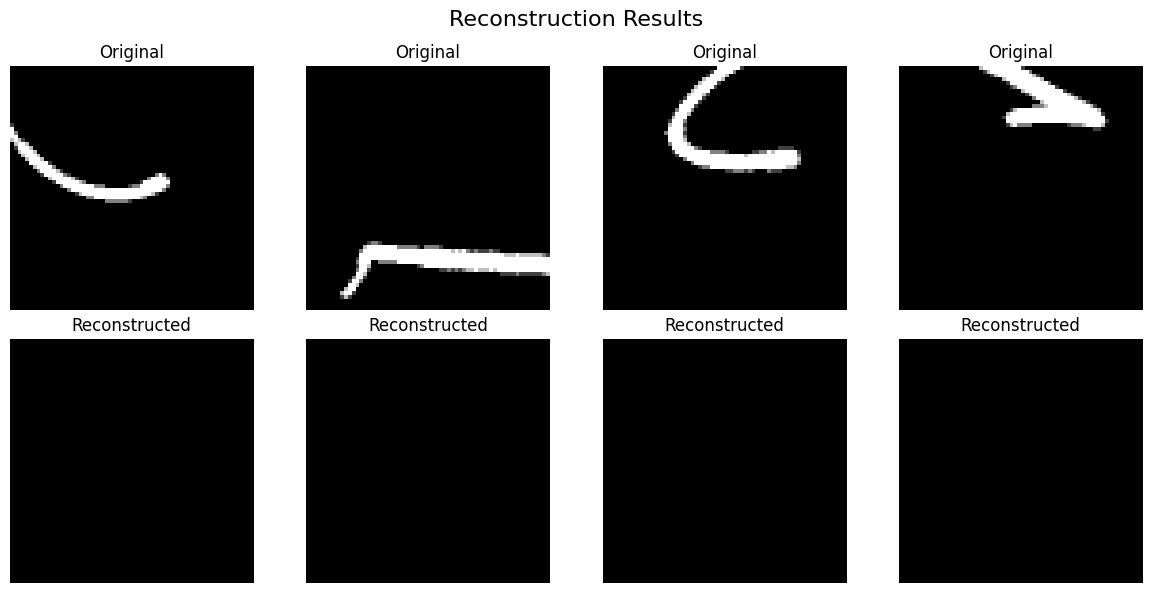

In [16]:
# ==================== 可视化重建效果 ====================
def visualize_reconstruction(model, dataset, device, num_samples=4):
    """可视化重建效果"""
    model.eval()
    
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))
    fig.suptitle('Reconstruction Results', fontsize=16)
    
    with torch.no_grad():
        for i in range(num_samples):
            # 获取样本
            img, _, _, _ = dataset.render_stroke()
            img_tensor = torch.from_numpy(img).float() / 255.0
            img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device)
            
            # 重建
            reconstructed, _ = model(img_tensor)
            
            # 显示原图
            axes[0, i].imshow(img, cmap='gray', vmin=0, vmax=255)
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # 显示重建图
            recon_img = reconstructed.cpu().squeeze().numpy()
            recon_img = (recon_img * 255).astype(np.uint8)
            axes[1, i].imshow(recon_img, cmap='gray', vmin=0, vmax=255)
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 运行可视化
visualize_reconstruction(model, dataset, device)

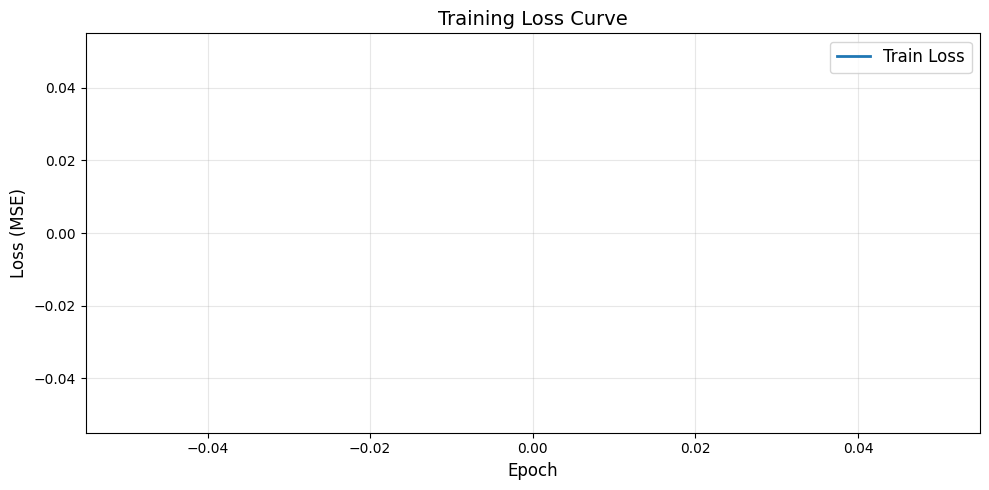


训练完成!
最佳损失: inf


In [14]:
# ==================== 绘制损失曲线 ====================
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss Curve', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n训练完成!")
print(f"最佳损失: {best_loss:.6f}")

In [ ]:
# ==================== 加载已保存的模型 ====================
def load_model(checkpoint_path, model, optimizer=None):
    """加载模型检查点"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # 这里需要根据实际模型结构调整
    # model.load_state_dict(checkpoint['model_state_dict'])
    
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    if optimizer and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print(f"加载模型: {checkpoint_path}")
    print(f"  Epoch: {epoch}")
    print(f"  Loss: {loss:.6f}")
    
    return epoch, loss

# 使用示例：
load_model('best_reconstruction.pth', model, optimizer)

加载模型: best_reconstruction.pth
  Epoch: 50
  Loss: 0.001221


(50, 0.001220614722254463)

In [ ]:
# ==================== 快速测试（小规模训练） ====================
# 如果想快速测试，可以修改这里的参数然后运行

test_config = {
    'batch_size': 16,
    'lr': 1e-3,
    'num_epochs': 3,
}

print("快速测试模式:")
for k, v in test_config.items():
    print(f"  {k}: {v}")

# 取消下面的注释来运行快速测试
# history = {'train_loss': []}
# best_loss = float('inf')
# 
# for epoch in range(1, test_config['num_epochs'] + 1):
#     model.train()
#     epoch_loss = 0.0
#     
#     for batch_idx, (imgs, labels) in enumerate(train_loader):
#         if batch_idx >= 10:  # 只训练 10 个 batch
#             break
#         
#         imgs = imgs.to(device)
#         optimizer.zero_grad()
#         reconstructed, embeddings = model(imgs)
#         loss = criterion(reconstructed, imgs)
#         loss.backward()
#         optimizer.step()
#         
#         epoch_loss += loss.item()
#         print(f"  Batch {batch_idx+1}/10, Loss: {loss.item():.6f}")
#     
#     avg_loss = epoch_loss / 10
#     history['train_loss'].append(avg_loss)
#     print(f"\nEpoch {epoch}: Loss = {avg_loss:.6f}\n")